In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from network import ConstantBirthNode, DynamicBirthNode, Network
from reactions import Reactions, CmeParameters, OdeParameters
from simulate import simulate_gillespie, simulate_ode
from analysis import CmeSimResults

In [2]:
DELTA = 1

node0 = ConstantBirthNode(deathrate=0.2, birthrate=0.2)
node1 = DynamicBirthNode(deathrate=0.2, birthrate=0.2, targetpop=60, controlstrength=0.01, delta=DELTA)
node2 = DynamicBirthNode(deathrate=0.1, birthrate=0.1, targetpop=60, controlstrength=0.01, delta=DELTA)

network = Network()
network.add_node(node0)
network.add_node(node1)
network.add_node(node2)
network.allocate_ids()

network.add_transport(node0, node1, rate = 0.05)
network.add_transport(node1, node0, rate = 0.05)
network.add_transport(node1, node2, rate = 0.03)
network.add_transport(node2, node1, rate = 0.03)

print("Nodes in the Network:")
for node in network.nodes: print(node)

print("\nEdges in the network:")
for s, d, in network.edges:
    print(s, d)

reactions = Reactions(network)

print("\nReactions:")
for reaction in reactions.reactions:
    print(reaction)

Nodes in the Network:
ConstantBirthNode(id:0)
DynamicBirthNode(id:1)
DynamicBirthNode(id:2)

Edges in the network:
ConstantBirthNode(id:0) DynamicBirthNode(id:1)
DynamicBirthNode(id:1) ConstantBirthNode(id:0)
DynamicBirthNode(id:1) DynamicBirthNode(id:2)
DynamicBirthNode(id:2) DynamicBirthNode(id:1)

Reactions:
BirthReaction(n0_t0, rate: 0.2)
BirthReaction(n0_t1, rate: 0.2)
BirthReaction(n1_t0, rate: Dynamic)
BirthReaction(n1_t1, rate: Dynamic)
BirthReaction(n2_t0, rate: Dynamic)
BirthReaction(n2_t1, rate: Dynamic)
DeathReaction(n0_t0, rate: 0.2)
DeathReaction(n0_t1, rate: 0.2)
DeathReaction(n1_t0, rate: 0.2)
DeathReaction(n1_t1, rate: 0.2)
DeathReaction(n2_t0, rate: 0.1)
DeathReaction(n2_t1, rate: 0.1)
TransportReaction(from: n0_t0, to: n1_t0,  rate: 0.05)
TransportReaction(from: n0_t1, to: n1_t1,  rate: 0.05)
TransportReaction(from: n1_t0, to: n0_t0,  rate: 0.05)
TransportReaction(from: n1_t1, to: n0_t1,  rate: 0.05)
TransportReaction(from: n1_t0, to: n2_t0,  rate: 0.03)
TransportRea

In [6]:
MAX_T = 20
TIME_POINTS = np.linspace(0, MAX_T, 1001)

start_statevec = np.array([10, 0, 10, 0, 10, 0])

Reaction Matrix:
[[ 1  0  0  0  0  0]
 [ 0  1  0  0  0  0]
 [ 0  0  1  0  0  0]
 [ 0  0  0  1  0  0]
 [ 0  0  0  0  1  0]
 [ 0  0  0  0  0  1]
 [-1  0  0  0  0  0]
 [ 0 -1  0  0  0  0]
 [ 0  0 -1  0  0  0]
 [ 0  0  0 -1  0  0]
 [ 0  0  0  0 -1  0]
 [ 0  0  0  0  0 -1]
 [-1  0  1  0  0  0]
 [ 0 -1  0  1  0  0]
 [ 1  0 -1  0  0  0]
 [ 0  1  0 -1  0  0]
 [ 0  0 -1  0  1  0]
 [ 0  0  0 -1  0  1]
 [ 0  0  1  0 -1  0]
 [ 0  0  0  1  0 -1]]
Reaction Rates:
[ 0.2   0.2  -1.   -1.   -1.   -1.    0.2   0.2   0.2   0.2   0.1   0.1
  0.05  0.05  0.05  0.05  0.03  0.03  0.03  0.03]
Statevec i:
[0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 2 3 4 5]
Dynamic Birth Parameters:
[2 4]
[0.  0.  0.2 0.2 0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0. ]
[ 0.  0. 60. 60. 60. 60.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[0.   0.   0.01 0.01 0.01 0.01 0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.  ]
[0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Simulatin

100%|██████████| 1000/1000 [00:00<00:00, 3971.94it/s]


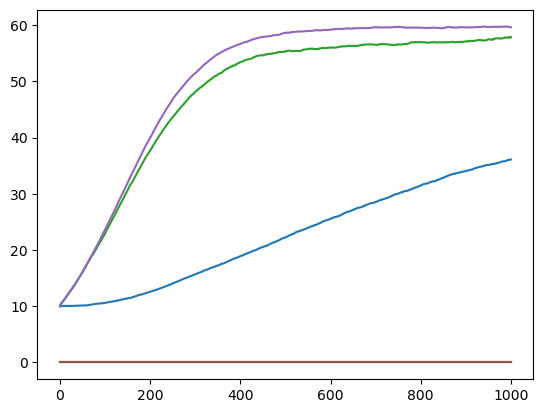

In [7]:
cme_param = CmeParameters(reactions)
print(cme_param)

REPLICATES = 1000
gill_results = simulate_gillespie(cme_param, TIME_POINTS, start_statevec, REPLICATES)
gill_results = CmeSimResults(gill_results)

plt.plot(gill_results.average.T)
plt.show()

global ODE_model
def ODE_model(t, z):
# Variables (<node.id>_<etype>):
	n0_t0, n0_t1, n1_t0, n1_t1, n2_t0, n2_t1 = z
# Terms for each variable:
	return [
# Δn0_t0/Δt	<birth>    <death>    <outflow>      <inflow>
		+n0_t0*0.2 -n0_t0*0.2 -n0_t0*(+0.05) +(+n1_t0*0.05) ,
# Δn0_t1/Δt	<birth>    <death>    <outflow>      <inflow>
		+n0_t1*0.2 -n0_t1*0.2 -n0_t1*(+0.05) +(+n1_t1*0.05) ,
# Δn1_t0/Δt	<birth>                                           <death>    <outflow>           <inflow>
		+n1_t0*np.max([0, 0.2+0.01*(60-n1_t0-(1*n1_t1))]) -n1_t0*0.2 -n1_t0*(+0.05+0.03) +(+n0_t0*0.05+n2_t0*0.03) ,
# Δn1_t1/Δt	<birth>                                           <death>    <outflow>           <inflow>
		+n1_t1*np.max([0, 0.2+0.01*(60-n1_t0-(1*n1_t1))]) -n1_t1*0.2 -n1_t1*(+0.05+0.03) +(+n0_t1*0.05+n2_t1*0.03) ,
# Δn2_t0/Δt	<birth>                                           <death>    <outflow>      <inflow>
		+n2_t0*np.max([0, 0.1+0.01*(60-n2_t0-(1*n2_t1))]) -n2_t0*0.1 -n2_t0*(+0.03) +(+n1_t0*0.03) ,


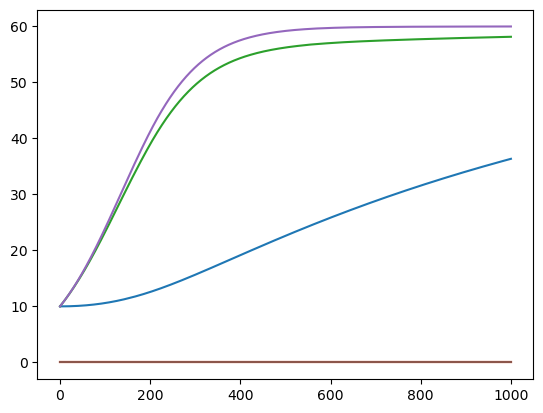

In [8]:
ode_param = OdeParameters(reactions)
print(ode_param)

ode_results = simulate_ode(ode_param, TIME_POINTS, start_statevec)

plt.plot(ode_results.T)
plt.show()

In [13]:
gill_results.raw.shape

(1000, 6, 1001)